In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import escnn
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Define representations

In [2]:
def build_D6_representation_from_generators(repr_r, repr_m):
    """
    Builds an escnn representation object for the group D6 from representations
    of the rotation and reflection group elements given as numpy arrays.
    """

    G = escnn.group.DihedralGroup(6)
    
    # Shorthand for the group elements
    e    = G.identity
    r, m = G.generators

    # The representation of the identity element is always the identity matrix.
    repr_e = np.eye(repr_r.shape[0])
    
    # Generate the representation of every element in D6 from the provided
    # representations of the generators.
    repr_dict = {
        e:              repr_e,
        r:              repr_r,
        r@r:            repr_r@repr_r,
        r@r@r:          repr_r@repr_r@repr_r,
        r@r@r@r:        repr_r@repr_r@repr_r@repr_r,
        r@r@r@r@r:      repr_r@repr_r@repr_r@repr_r@repr_r,
        m:              repr_m,
        m@r:            repr_m@repr_r,
        m@r@r:          repr_m@repr_r@repr_r,
        m@r@r@r:        repr_m@repr_r@repr_r@repr_r,
        m@r@r@r@r:      repr_m@repr_r@repr_r@repr_r@repr_r,
        m@r@r@r@r@r:    repr_m@repr_r@repr_r@repr_r@repr_r@repr_r,
    }

    return escnn.group.representation.build_from_discrete_group_representation(
        representation=repr_dict, 
        name="input_repr", 
        group=G,
        supported_nonlinearities=[]
    )


def get_design_representation():
    """
    Returns the representation of the group acting on the design parameters
    """

    # Design representations are permutation matrices
    return build_D6_representation_from_generators(
        repr_r = np.roll(np.eye(12), shift=2, axis=0),  # Roll-matrix
        repr_m = np.flip(np.eye(12), axis=0)            # Reverse-matrix
    )


def get_S_representation():
    """
    Returns the representation of the group acting on the scattering parameters
    """

    # S representations have been calculated analytically using procedure
    # described in the paper.
    c = np.cos(2*np.pi/6)
    s = np.sin(2*np.pi/6)
    return build_D6_representation_from_generators(
        repr_r = np.array([
            [c**2,  -2*c*s,     s**2],
            [c*s,   c**2-s**2,  -c*s],
            [s**2,  2*c*s,      c**2]
        ]),
        repr_m = np.array([
            [1, 0, 0],
            [0,-1, 0],
            [0, 0, 1]
        ])
    )

# Load dataset

In [3]:
class PhC_Dataset(Dataset):
    def __init__(self, data_dict, augment=False):

        # Design paramters, d = (d_1, d_2, ..., d_12)
        self.parameters  = data_dict["parameters"].astype(np.float32)
        
        # Flattened S parameters, S = (Sxx, Syx, Syy)
        self.S = np.stack([
            data_dict["S"][:,2,0],
            data_dict["S"][:,3,0],
            data_dict["S"][:,3,1]
        ], axis=1).astype(np.complex64)

        assert self.parameters.shape[0] == self.S.shape[0]
        self.size = self.parameters.shape[0]
        
        # Should augmentation be applied when samples are loaded?
        self.augment = augment

        self.group = escnn.group.DihedralGroup(6)
        self.d_repr = get_design_representation()
        self.S_repr = get_S_representation()

    def __len__(self):
        return self.size

    def __getitem__(self, idx):

        d  = self.parameters[idx]
        S  = self.S[idx]
        
        if self.augment:

            # Sample a random element of the group
            g = self.group.sample()

            # Act with the group element on the design and scattering parameters
            d = (self.d_repr(g) @ d).astype(np.float32)
            S = (self.S_repr(g) @ S).astype(np.complex64)

        return d, S
    
# Load data dictionaries
train_data_dict = np.load("dataset/train.npz")
test_data_dict = np.load("dataset/test.npz")

# Split training data into training and validation
train_dataset = PhC_Dataset({
    "parameters": train_data_dict["parameters"][:10000],
    "S": train_data_dict["S"][:10000]
})
val_dataset = PhC_Dataset({
    "parameters": train_data_dict["parameters"][10000:],
    "S": train_data_dict["S"][10000:]
})

# Create test dataset
test_dataset = PhC_Dataset(test_data_dict)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataloader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)

print("Number of training samples:", len(train_dataloader.dataset))
print("Number of validation samples:", len(val_dataloader.dataset))
print("Number of testing samples:", len(test_dataloader.dataset))

Number of training samples: 10000
Number of validation samples: 2000
Number of testing samples: 4000


# Build Models

### Standard MLP

In [ ]:
class MLP(nn.Module):
    """
    Standard MLP mapping design vector (12 real numbers) to scattering paramters
    (3 imaginary numbers).
    """

    def __init__(self, hidden_layers=5, hidden_layer_width=12*32, batch_norm=False):
        super().__init__()

        self.hidden_layers      = hidden_layers
        self.hidden_layer_width = hidden_layer_width
        self.batch_norm         = batch_norm

        layers = []

        # Input layer
        layers.append(nn.Linear(12, self.hidden_layer_width))
        layers.append(nn.ReLU())

        # Hidden layers
        for i in range(hidden_layers - 1):
            if self.batch_norm: layers.append(nn.BatchNorm1d(self.hidden_layer_width))
            layers.append(nn.Linear(self.hidden_layer_width, self.hidden_layer_width))
            layers.append(nn.ReLU())
            
        # Sequential module contraining all layers until the output
        self.net = nn.Sequential(*layers)

        # Output layers (one for real part, one for imaginary)
        self.out_re = nn.Linear(self.hidden_layer_width, 3)
        self.out_im = nn.Linear(self.hidden_layer_width, 3)

    def forward(self, x): 
        x = self.net(x)
        return self.out_re(x) + 1j * self.out_im(x)

### Equivariant MLP

In [ ]:
class EMLP(nn.Module):

    def __init__(self, hidden_layers=5, hidden_feature_field_count=32, batch_norm=False):
        super().__init__()

        self.hidden_layers = hidden_layers
        self.hidden_feature_field_count = hidden_feature_field_count
        self.batch_norm = batch_norm

        # The EMLP is implemented as a special case of an E(n)-steerable CNN
        # on a 0-dimensional space
        self.group = escnn.group.DihedralGroup(6)
        self.gspace = escnn.gspaces.GSpace0D(self.group)

        # Define how the group should act on the features of each layer
        self.input_repr  = get_design_representation()  # Input is design vectors
        self.hidden_repr = self.gspace.regular_repr     # Hidden layers use regular representation
        self.output_repr = get_S_representation()       # Output is S paramters

        # Define field types
        self.input_field_type  = escnn.nn.FieldType(self.gspace, [self.input_repr])
        self.hidden_field_type = escnn.nn.FieldType(self.gspace, [self.hidden_repr]*hidden_feature_field_count)
        self.output_field_type = escnn.nn.FieldType(self.gspace, [self.output_repr])

        layers = []

        # Input layer
        layers.append(escnn.nn.Linear(self.input_field_type, self.hidden_field_type))
        layers.append(escnn.nn.ReLU(self.hidden_field_type))

        # Hidden layers
        for i in range(hidden_layers-1):
            if self.batch_norm: layers.append(escnn.nn.InnerBatchNorm(self.hidden_field_type))
            layers.append(escnn.nn.Linear(self.hidden_field_type, self.hidden_field_type))
            layers.append(escnn.nn.ReLU(self.hidden_field_type))
            
        # Sequential module contraining all layers until the output
        self.net = escnn.nn.SequentialModule(*layers)

        # Output layers (one for real part, one for imaginary)
        self.out_re = escnn.nn.Linear(self.hidden_field_type, self.output_field_type)
        self.out_im = escnn.nn.Linear(self.hidden_field_type, self.output_field_type)

    def forward(self, x):
        # Input features is torch tensor, so we first wrap it in 
        # a GeometricTensor, then unwrap before returning with .tensor
        x = escnn.nn.GeometricTensor(x, self.input_field_type)
        x = self.net(x)
        return self.out_re(x).tensor + 1j * self.out_im(x).tensor

# Train models

### Generic train and test loops

In [ ]:
import torch

def train_epoch(dataloader, model, loss_fn, optimizer, print_progress=True):
    size = len(dataloader.dataset)

    model.train()
    cumulative_loss   = 0
    processed_batches = 0
    for (x, t) in dataloader:
        x    = x.to(device)
        t    = t.to(device)

        optimizer.zero_grad(set_to_none=True)

        y = model(x)
        loss = loss_fn(y, t)

        loss.backward()

        optimizer.step()
        
        loss_val = loss.detach().item()
        cumulative_loss   += loss_val
        processed_batches += 1

        if print_progress:
            processed_samples = processed_batches * dataloader.batch_size
            print(f"loss: {loss_val:>10.5f}  [{processed_samples:>5d}/{size:>5d}]", end="\r")

    return cumulative_loss / processed_batches


def test_epoch(dataloader, model, loss_fn):

    cumulative_loss   = 0
    processed_batches = 0

    model.eval()
    with torch.no_grad():
        
        for x, t in dataloader:
            x    = x.to(device)
            t    = t.to(device)

            y = model(x)

            cumulative_loss += loss_fn(y, t).detach().item()
            processed_batches += 1

    return cumulative_loss / processed_batches

Using cuda device


### Run training

In [ ]:
# Select model here (MLP, MLP-A, or EMLP)
model_name = "EMLP"

if model_name == "MLP":
    model = MLP(hidden_layers=5, hidden_layer_width=32*12, batch_norm=False).to(device)
    train_dataloader.dataset.augment = False
    lr, wd = 1.3e-3, 7.9e-6 # Optimized hyperparameters
elif model_name == "MLP-A":
    model = MLP(hidden_layers=10, hidden_layer_width=32*12, batch_norm=False).to(device)
    train_dataloader.dataset.augment = True
    lr, wd = 2.5e-4, 1.5e-7
elif model_name == "EMLP":
    model = EMLP(hidden_layers=5, hidden_feature_field_count=12, batch_norm=False).to(device)
    train_dataloader.dataset.augment = False
    lr, wd = 2.3e-3, 2.4e-5
else:
    raise Exception("Unknown model!")

# Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

# Define loss function
class MSE(nn.Module):
    def forward(self, y, t): return torch.mean(torch.square(torch.abs(y - t)))
loss_fn = MSE()

train_losses = []
val_losses = []
# 1000 epochs were used to evaluate the models in the paper
for epoch in range(100):
    
    # Gradient step and validation
    train_loss = train_epoch(train_dataloader, model, loss_fn, optimizer, print_progress=True)
    val_loss  = test_epoch(val_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print progress
    print(f"Epoch {epoch:>7} - train MSE: {train_loss:.5f} - val MSE: {val_loss:.5f}")

test_loss  = test_epoch(test_dataloader, model, loss_fn)
print(f"Test MSE: {test_loss:.5f}")

Epoch       0 - train MSE: 0.08815 - val MSE: 0.05363
Epoch       1 - train MSE: 0.03281 - val MSE: 0.02145
Epoch       2 - train MSE: 0.01769 - val MSE: 0.01554
Epoch       3 - train MSE: 0.01357 - val MSE: 0.01291
Epoch       4 - train MSE: 0.01174 - val MSE: 0.01184
Epoch       5 - train MSE: 0.01044 - val MSE: 0.01061
Epoch       6 - train MSE: 0.00997 - val MSE: 0.01060
Epoch       7 - train MSE: 0.00924 - val MSE: 0.00939
Epoch       8 - train MSE: 0.00872 - val MSE: 0.00919
Epoch       9 - train MSE: 0.00837 - val MSE: 0.00871
Epoch      10 - train MSE: 0.00801 - val MSE: 0.00848
Epoch      11 - train MSE: 0.00771 - val MSE: 0.00811
Epoch      12 - train MSE: 0.00783 - val MSE: 0.00781
Epoch      13 - train MSE: 0.00746 - val MSE: 0.00865
Epoch      14 - train MSE: 0.00729 - val MSE: 0.00768
Epoch      15 - train MSE: 0.00702 - val MSE: 0.00736
Epoch      16 - train MSE: 0.00719 - val MSE: 0.00761
Epoch      17 - train MSE: 0.00689 - val MSE: 0.00722
Epoch      18 - train MSE: 0

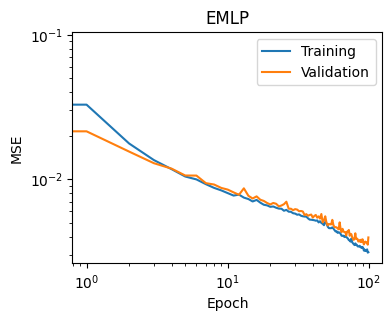

In [8]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.plot(train_losses, label="Training")
ax.plot(val_losses, label="Validation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax.set_title(model_name)
ax.legend()

# Inference

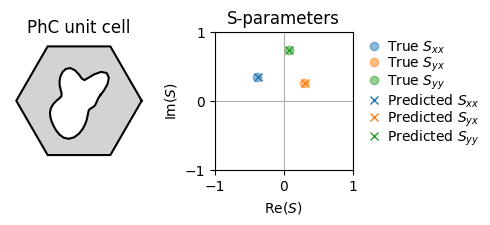

In [9]:
from parameterization import visualize

# Load a sample from the test set
sample_id = 42  # <-- Select sample here
design = test_dataloader.dataset.parameters[sample_id]
S_true = test_dataloader.dataset.S[sample_id]

# Predict scattering parameters of sample using trained model
model.eval()
with torch.no_grad():
    S_pred = model(torch.tensor(design).to(device)[None])[0].cpu().numpy()

fig, axs = plt.subplots(1, 2, figsize=(5,2.5))

# Plot unit cell
ax = axs[0]
ax.set_title("PhC unit cell")
visualize(ax, design, plot_control_points=False)

# Plot true S-paramters and model prediction
ax = axs[1]
ax.set_title("S-parameters")
ax.plot(np.real(S_true[0]), np.imag(S_true[0]), "C0o", label="True $S_{xx}$", alpha=0.5)
ax.plot(np.real(S_true[1]), np.imag(S_true[1]), "C1o", label="True $S_{yx}$", alpha=0.5)
ax.plot(np.real(S_true[2]), np.imag(S_true[2]), "C2o", label="True $S_{yy}$", alpha=0.5)

ax.plot(np.real(S_pred[0]), np.imag(S_true[0]), "C0x", label="Predicted $S_{xx}$")
ax.plot(np.real(S_pred[1]), np.imag(S_true[1]), "C1x", label="Predicted $S_{yx}$")
ax.plot(np.real(S_pred[2]), np.imag(S_true[2]), "C2x", label="Predicted $S_{yy}$")

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.grid()
ax.set_xlabel("Re($S$)")
ax.set_ylabel("Im($S$)")
ax.set_aspect(1)
ax.legend(loc="upper left", bbox_to_anchor=(1,1), borderpad=0, frameon=False, labelspacing=0, handletextpad=0)

fig.tight_layout()
